In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
################################################ ML-Time Series Tempate ################################################
# Input Arguments file: File name with path (Eg: 'D:/data/dataread.csv'), f_type: File Type (Eg: 'csv',default csv)
def file_todataframe(file,f_type):
    if f_type == 'csv':  
        return pd.read_csv(file)
    elif f_type == 'excel': 
        return pd.read_excel(file)
    elif f_type == 'json': 
        return pd.read_json(file)
    
# This function display shape, data type, data near head and tail of given data fram.
# Input Arguments df: dataframe, n: No f data points to display
def df_details(d_f,n):
    print('Data Types of Column: \n',d_f.dtypes)
    print('\n Size of Datarame: ',d_f.shape)
    print('\n Top and bottom ',n,' rows: \n')
    display(d_f.head(n).append(d_f.tail(n)))
    
# This function give deatials for missing values in data
# Input Arguments df: dataframe
def miss_ch(d_f):
    print('Available data with no nulls: ', d_f.dropna().shape[0])
    display('Deatils of Null values column wise',d_f.isnull().sum())
    

# Function for Canging column type
# Input Arguments df: dataframe, col_int: Columns of intrest (Eg: ['Sale','Customer'],['all'] default 'all'), 
# dtyp: New data types of coloumn default int
def col_dtype(d_f,col_int,dtyp = int):
    d_f = deep_copy(d_f)
    av_fun = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','int','float','str','category']
    col_nam = d_f.columns
    #Checking Parameter Column names
    if not all(i in col_nam for i in col_int):
        print("Invalid column name")
        return 
    #Checking Parameter available function
    if not dtyp in av_fun:
        print("Invalid data type")
        return
    
    d_f[col_int] = d_f[col_int].astype(dtyp,errors='ignore')
    return d_f

def data_num(d_f,col_int = 'all',func = 'all',scat = None):
    from scipy.stats import shapiro
    from statsmodels.graphics.gofplots import qqplot
    av_func = ['hist','boxplot','scatter','describe','normality']
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_nam = d_f.select_dtypes(include=numerics).columns
    #Checking Parameter Column names
    if col_int == 'all':
        col_int = col_nam
    elif not all(i in col_nam for i in col_int):
        print("Invalid column name")
        return 
    
    #Checking Parameter available function
    if func == 'all':
        func = av_func
    elif not all(i in av_gp for i in graph):
        print("Invalid Graph type, select 'distplot','boxpot','scatterplot','describe','normality'")
        return
    if scat is None:
        scat = d_f.columns[0]
    
    
    for fn in func:
        if fn == 'describe':
            display("Statictical Details",d_f[col_int].describe())
        else:
            for col in col_int:
                if fn == 'normality':
                    #qqplot(df[col])
                    print("Normality Test for: ",col)
                    stat, p = shapiro(d_f[col])
                    if p > 0.05:
                        print('Sample looks Gaussian. Statistics=%.3f, p=%.3f'% (stat, p))
                    else:
                        print('Sample does not look Gaussian. Statistics=%.3f, p=%.3f'% (stat, p))
                elif fn == 'scatter':
                    display(col)
                    plt.scatter(d_f[col],d_f[scat])  
                    plt.show()
                else:
                    display(col)
                    getattr(plt, fn)(d_f[col])   
                    plt.show()

## Function to return SL problem by taking a Time series data
# lag define the the how many and how much shifts to be included, for lag = [1,3] : will include one t-1 and t-3 data columns
def ts2sl(d_f,col, lag=[1,2]):
    d_f = d_f.copy(deep=True)
    x = 1
    for i in lag:
        xst = 'x'+ str(x)
        d_f[xst] = d_f[col].shift(i)
        x = x+1
    xst = 'x'+ str(x)   
    d_f.rename(columns = {col: 'y'}, inplace = True)
    return d_f

# This function fill missing values
def fill_miss(d_f,col_int = 'all',metd = None):
    col_nam = d_f.columns
    av_method = ['bfill', 'pad', 'ffill', 'linear','mean']
    
    if not col_int in col_nam:
        print("Invalid column name")
        return d_f
    if metd == None:
        return d_f
    elif (metd == 'mean'):
        d_f[col_int] = d_f[col_int].fillna(value=d_f[col_int].mean()) 
        return d_f
    elif metd == 'linear':
        d_f[col_int] = d_f[col_int].interpolate(method = 'linear') 
        return  d_f
    elif  metd in av_method:
        d_f[col_int] = d_f[col_int].fillna(method = metd)
        return d_f
    else:
        print("Invalid fill type")
        return d_f

# Project Part#1 

## Using 20 different features forecasting inflation

## Wrangling through data

In [72]:
# Reading File
df =  file_todataframe('CPI_Urban.xls','excel')

In [13]:
df_details(df,5)

Data Types of Column: 
 Date     datetime64[ns]
CPI             float64
ER              float64
M0              float64
M2              float64
RES             float64
REM             float64
IPLSM           float64
TB              float64
Disr            float64
OIL             float64
USIPI           float64
PSC             float64
PSB             float64
LR              float64
REER            float64
WPI             float64
WCPI            float64
WP                int64
Wfood           float64
dtype: object

 Size of Datarame:  (378, 20)

 Top and bottom  5  rows: 



,Date,CPI,ER,M0,M2,RES,REM,IPLSM,TB,Disr,OIL,USIPI,PSC,PSB,LR,REER,WPI,WCPI,WP,Wfood
0,1991-01-01,13.238078,22.129630,1.573830e+05,3.470580e+05,1451.000000,138.560000,49.270033,7.750,10.0,19.40,60.600000,1.812190e+05,1.805880e+05,10.770000,87.935019,11.878820,43.681717,112,65.420205
1,1991-02-01,13.238078,22.205375,1.603250e+05,3.490440e+05,1451.000000,123.950000,45.954554,7.750,10.0,14.45,60.200000,1.832870e+05,1.816390e+05,10.770000,87.666674,11.896905,44.393352,112,66.561185
2,1991-03-01,13.238078,22.559057,1.682910e+05,3.506650e+05,1451.000000,114.750000,47.200370,7.750,10.0,14.85,59.800000,1.848760e+05,1.976920e+05,10.770000,86.341940,11.859039,44.884438,112,67.642114
3,1991-04-01,13.238078,23.250155,1.682260e+05,3.527060e+05,1451.000000,115.500000,39.002094,8.790,10.0,15.35,60.000000,1.842070e+05,2.000090e+05,10.770000,87.674106,12.081717,45.370196,112,65.900617
4,1991-05-01,13.238078,23.742007,1.721270e+05,3.551370e+05,1451.000000,125.210000,38.017497,9.365,10.0,15.90,60.400000,1.828190e+05,1.991850e+05,10.770000,88.385929,12.277832,45.822579,112,64.375307
373,2022-02-01,NaN,171.900000,8.676084e+06,2.531512e+07,24534.193682,3040.084678,164.390900,7.440,7.0,57.14,108.322062,7.847463e+06,1.568747e+07,7.844589,102.106077,160.275300,120.143752,1650,146.178478
374,2022-03-01,NaN,173.100000,8.676084e+06,2.531512e+07,24926.740781,3070.485525,167.913500,7.440,7.0,57.14,108.322062,7.898490e+06,1.597758e+07,7.844589,102.818859,160.275300,120.143752,1650,147.919985
375,2022-04-01,NaN,174.300000,8.676084e+06,2.531512e+07,25325.568633,3101.190380,149.207000,7.440,7.0,57.14,108.322062,7.841545e+06,1.605970e+07,7.844589,103.531641,160.275300,120.143752,1650,134.092993
376,2022-05-01,NaN,175.600000,8.676084e+06,2.531512e+07,25730.777731,3132.202284,144.323900,7.440,7.0,57.14,108.322062,8.112747e+06,1.637087e+07,7.844589,104.303822,160.275300,120.143752,1650,135.433923
377,2022-06-01,NaN,176.800000,8.676084e+06,2.531512e+07,26142.470175,3163.524306,138.987100,7.440,7.0,57.14,108.322062,8.004842e+06,1.632170e+07,7.844589,105.016605,160.275300,120.143752,1650,136.003519


In [14]:
# Checking for missing values
miss_ch(df)

Available data with no nulls:  364


'Deatils of Null values column wise'

Date      0
CPI      14
ER        0
M0        0
M2        0
RES       0
REM       0
IPLSM     0
TB        0
Disr      0
OIL       0
USIPI     0
PSC       0
PSB       0
LR        0
REER      0
WPI       0
WCPI      0
WP        0
Wfood     0
dtype: int64

**No missing values in data as CPI is the variable need to be forcasted**

'CPI'

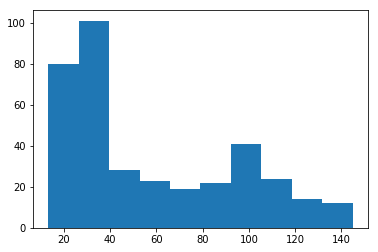

'ER'

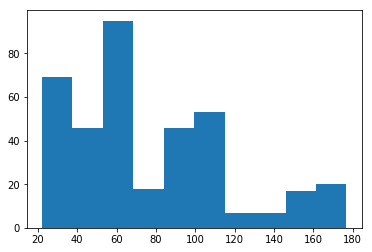

'M0'

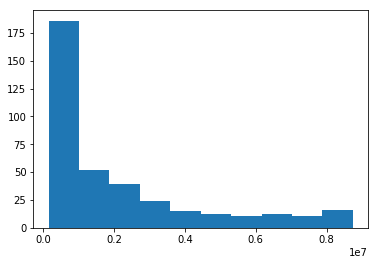

'M2'

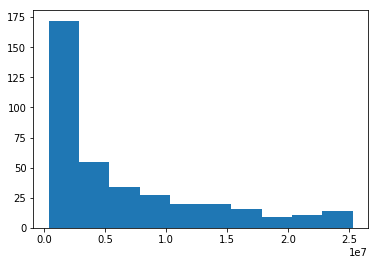

'RES'

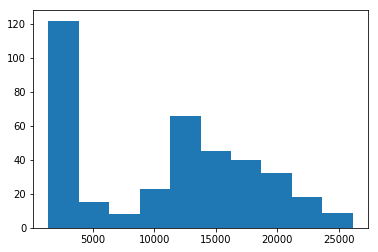

'REM'

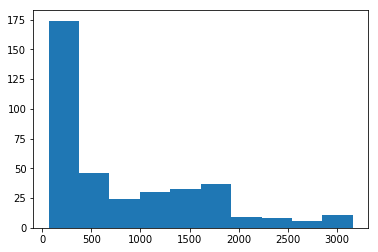

'IPLSM'

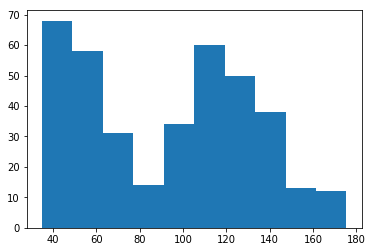

'TB'

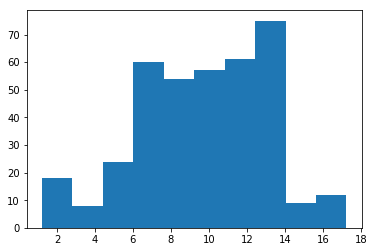

'Disr'

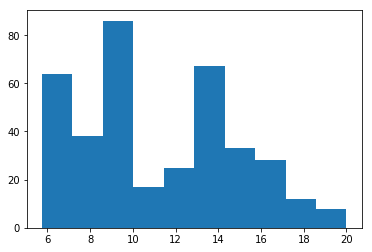

'OIL'

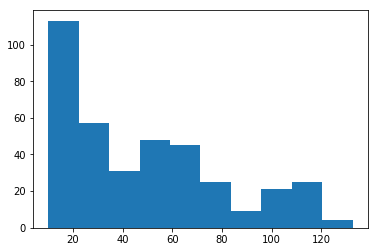

'USIPI'

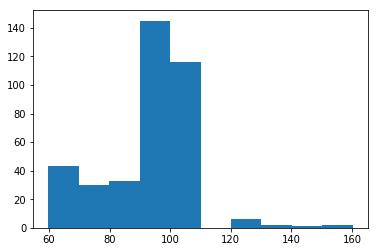

'PSC'

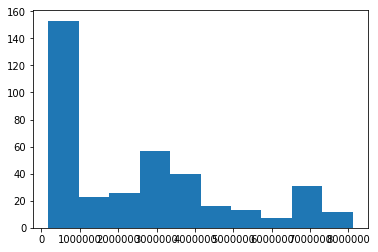

'PSB'

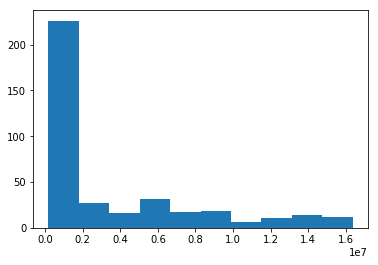

'LR'

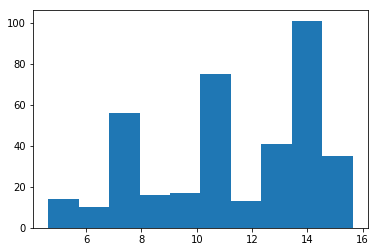

'REER'

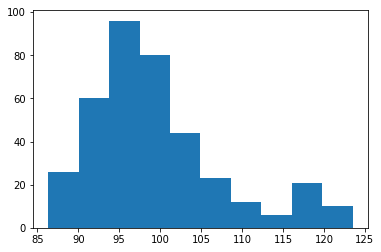

'WPI'

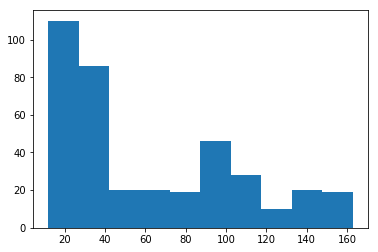

'WCPI'

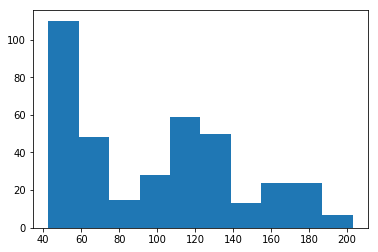

'WP'

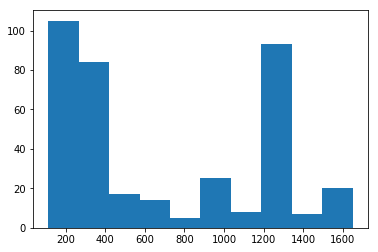

'Wfood'

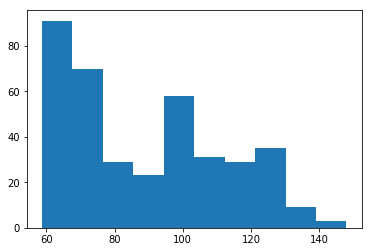

'CPI'

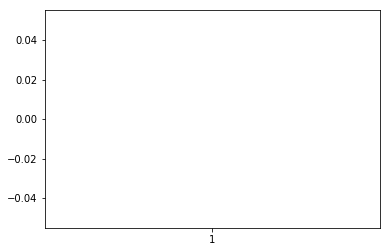

'ER'

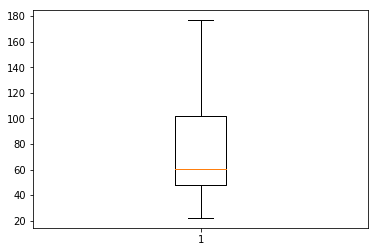

'M0'

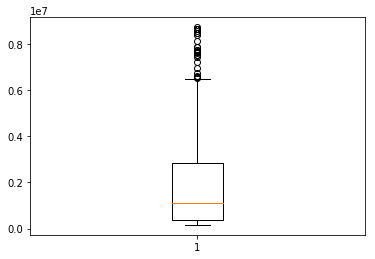

'M2'

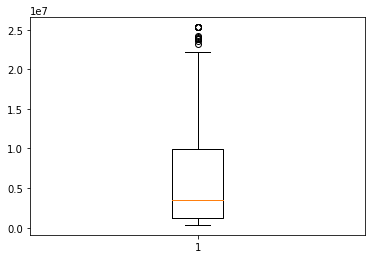

'RES'

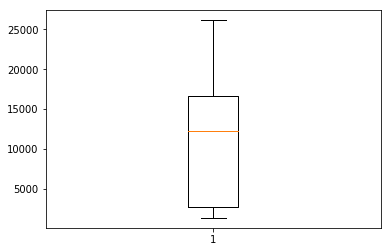

'REM'

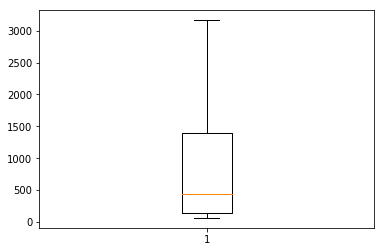

'IPLSM'

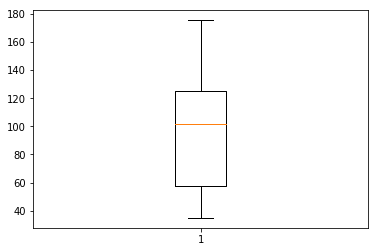

'TB'

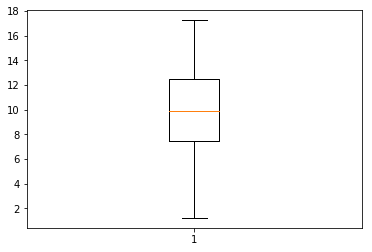

'Disr'

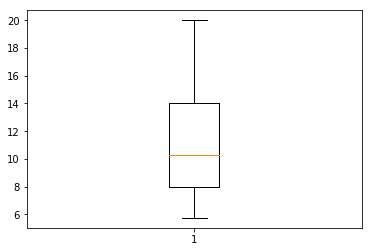

'OIL'

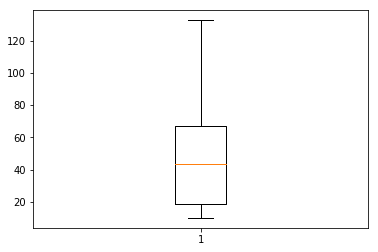

'USIPI'

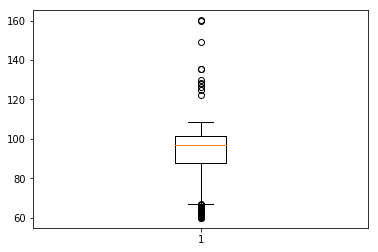

'PSC'

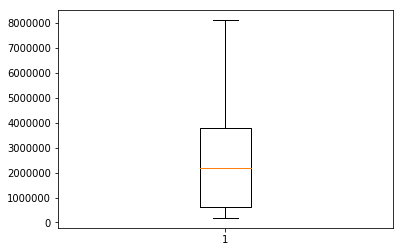

'PSB'

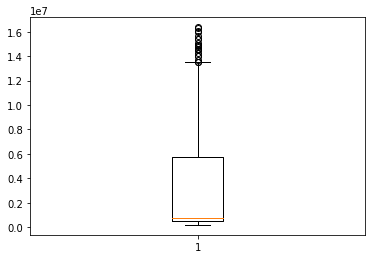

'LR'

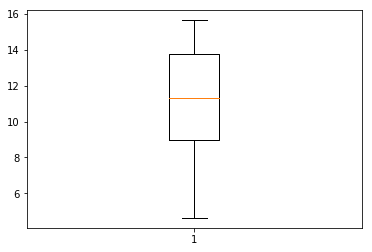

'REER'

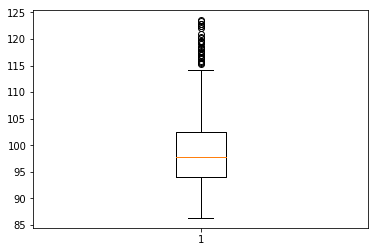

'WPI'

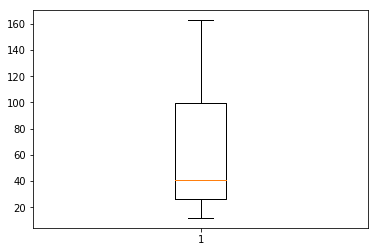

'WCPI'

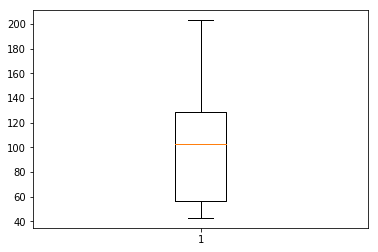

'WP'

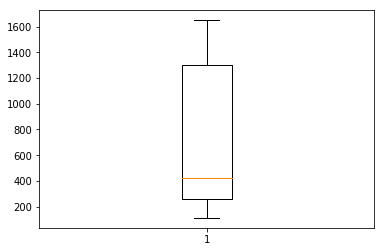

'Wfood'

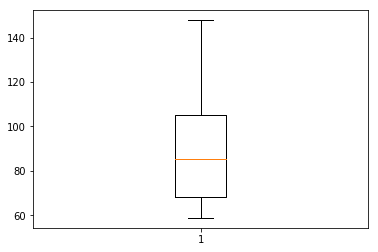

'CPI'

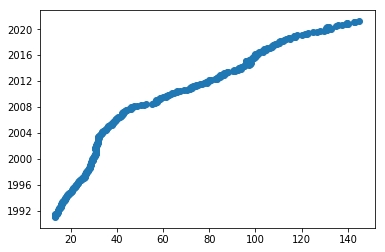

'ER'

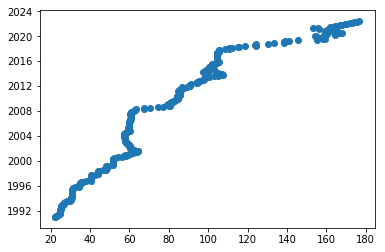

'M0'

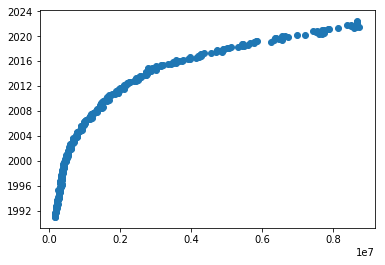

'M2'

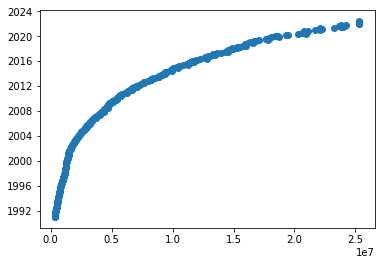

'RES'

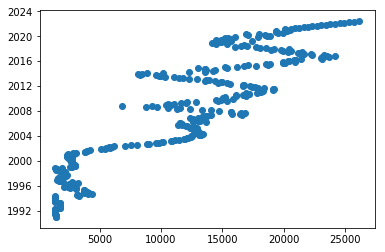

'REM'

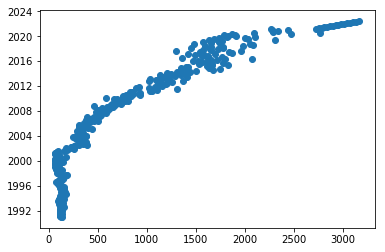

'IPLSM'

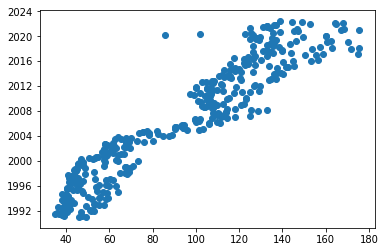

'TB'

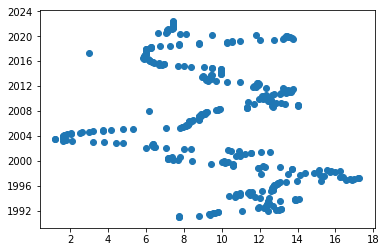

'Disr'

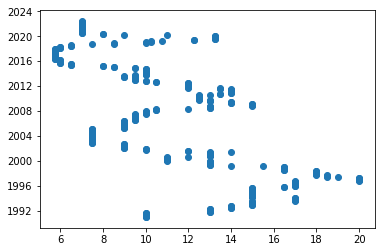

'OIL'

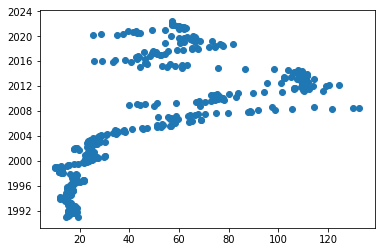

'USIPI'

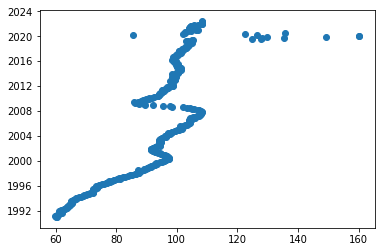

'PSC'

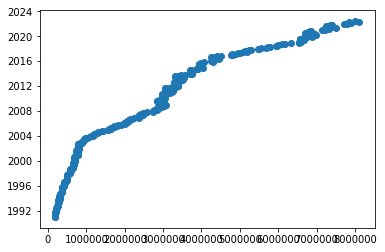

'PSB'

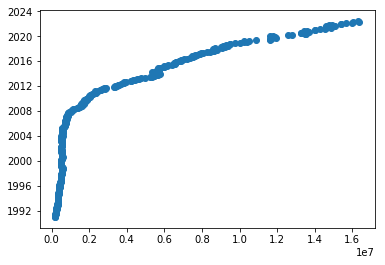

'LR'

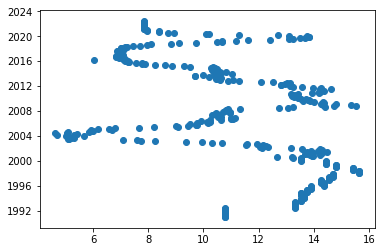

'REER'

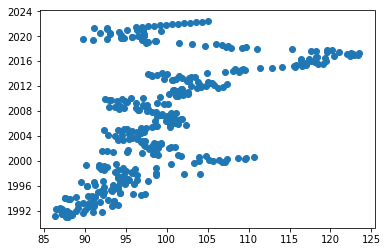

'WPI'

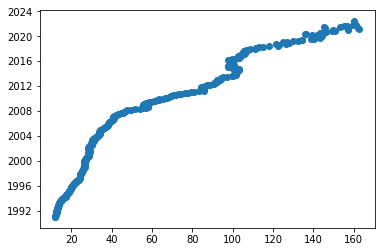

'WCPI'

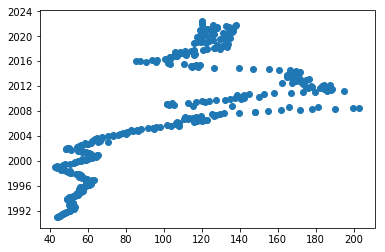

'WP'

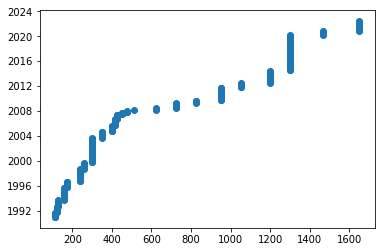

'Wfood'

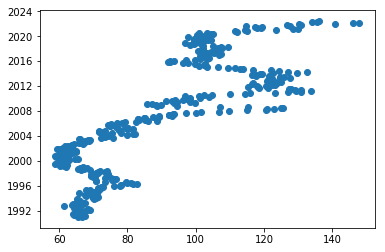

'Statictical Details'

,CPI,ER,M0,M2,RES,REM,IPLSM,TB,Disr,OIL,USIPI,PSC,PSB,LR,REER,WPI,WCPI,WP,Wfood
count,364.000000,378.000000,3.780000e+02,3.780000e+02,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,3.780000e+02,3.780000e+02,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,56.986987,76.193293,2.120560e+06,6.403818e+06,10866.370398,806.636683,93.188547,9.700831,11.226190,48.597982,93.366445,2.582153e+06,3.468796e+06,11.292994,99.535756,61.718838,99.558735,694.634921,89.341799
std,37.195332,39.876103,2.354669e+06,6.741169e+06,7185.086582,793.234181,38.274582,3.402985,3.702922,32.032425,15.266429,2.236541e+06,4.390460e+06,2.922926,8.130306,44.273486,44.090741,506.386076,22.721444
min,13.238078,22.129630,1.573830e+05,3.470580e+05,1369.000000,64.140000,34.842674,1.211600,5.750000,10.050000,59.800000,1.812190e+05,1.805880e+05,4.630000,86.341940,11.859039,42.670000,112.000000,58.770000
25%,28.184862,48.121656,3.919688e+05,1.226660e+06,2756.000000,137.547500,57.548364,7.440000,8.000000,18.525000,87.700000,6.256700e+05,5.165492e+05,8.955000,94.080734,26.184420,56.237500,260.000000,68.062500
50%,39.737289,60.698947,1.098100e+06,3.456018e+06,12323.576366,446.155000,101.426862,9.880860,10.250000,43.370000,96.850000,2.168366e+06,7.580562e+05,11.285000,97.712235,40.602759,102.985000,420.000000,85.175000
75%,91.479375,101.769335,2.842353e+06,9.931084e+06,16647.862761,1399.040000,124.820632,12.440437,14.000000,67.092500,101.600000,3.770835e+06,5.715707e+06,13.755000,102.419950,99.555668,128.470000,1300.000000,105.000000
max,144.910000,176.800000,8.741197e+06,2.531512e+07,26142.470175,3163.524306,175.490000,17.246000,20.000000,132.620000,160.248190,8.112747e+06,1.637087e+07,15.640000,123.513341,162.730000,202.960000,1650.000000,147.919985


Normality Test for:  CPI
Sample looks Gaussian. Statistics=nan, p=1.000
Normality Test for:  ER
Sample does not look Gaussian. Statistics=0.914, p=0.000
Normality Test for:  M0
Sample does not look Gaussian. Statistics=0.777, p=0.000
Normality Test for:  M2
Sample does not look Gaussian. Statistics=0.817, p=0.000
Normality Test for:  RES
Sample does not look Gaussian. Statistics=0.912, p=0.000
Normality Test for:  REM
Sample does not look Gaussian. Statistics=0.840, p=0.000
Normality Test for:  IPLSM
Sample does not look Gaussian. Statistics=0.935, p=0.000
Normality Test for:  TB
Sample does not look Gaussian. Statistics=0.976, p=0.000
Normality Test for:  Disr
Sample does not look Gaussian. Statistics=0.955, p=0.000
Normality Test for:  OIL
Sample does not look Gaussian. Statistics=0.895, p=0.000
Normality Test for:  USIPI
Sample does not look Gaussian. Statistics=0.891, p=0.000
Normality Test for:  PSC
Sample does not look Gaussian. Statistics=0.878, p=0.000
Normality Test for:  PSB


In [15]:
# Analysing data using template function by ploting the series
data_num(df,col_int = 'all',func = 'all',scat = None)

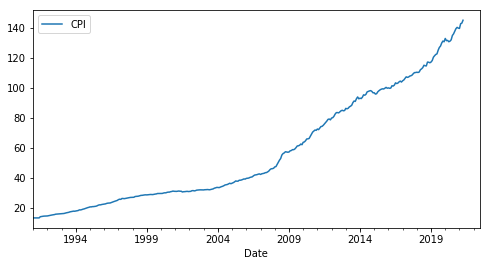

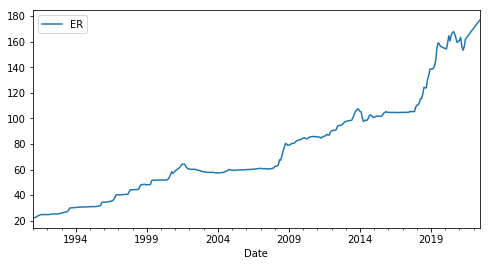

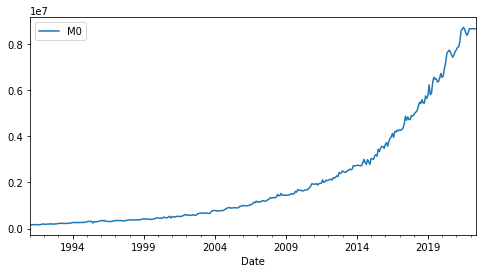

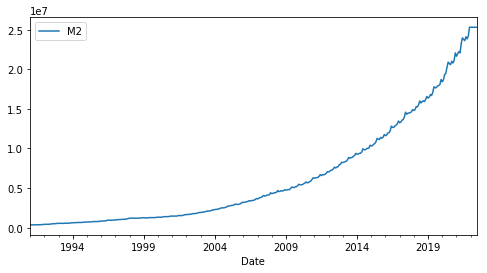

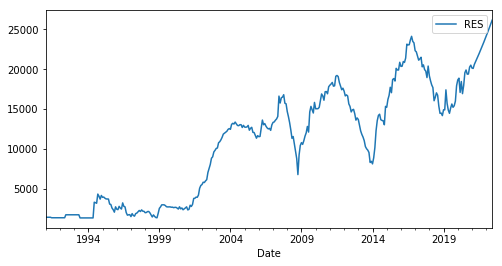

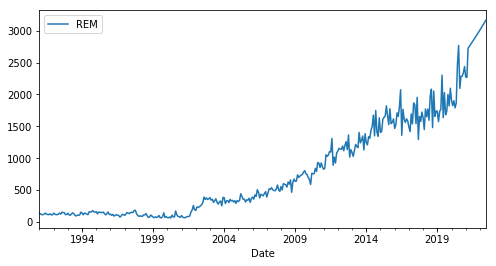

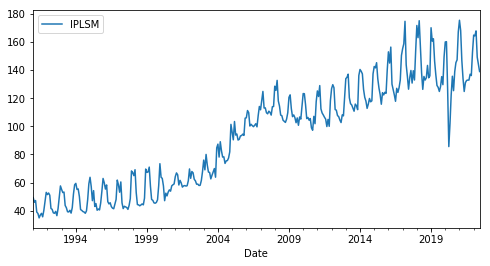

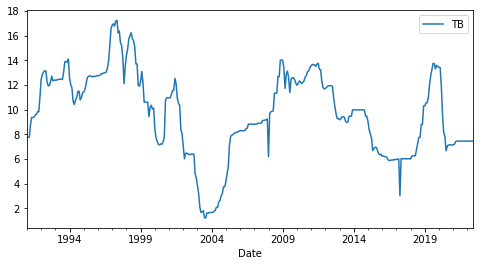

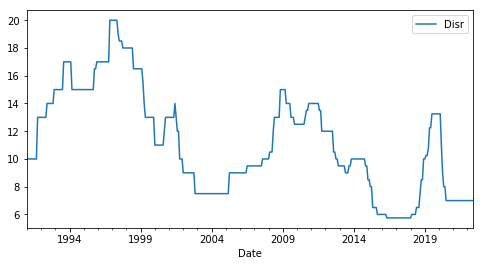

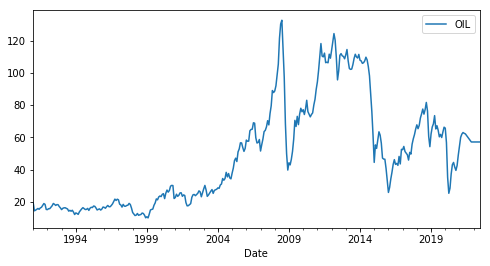

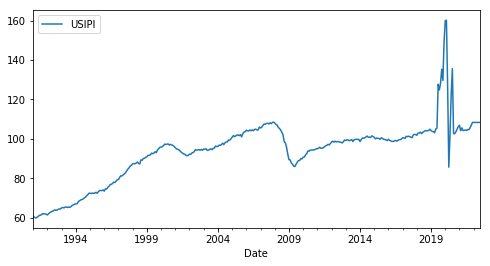

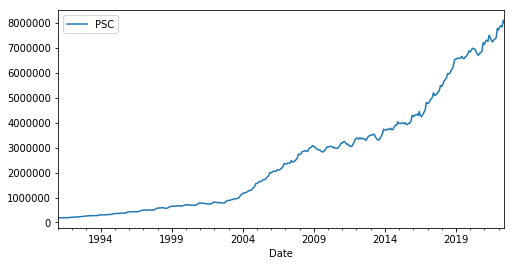

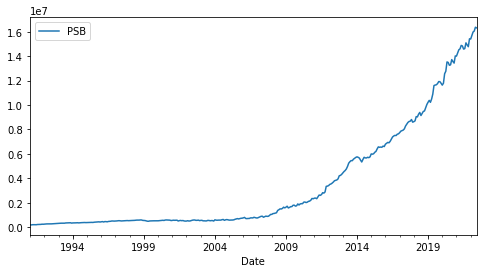

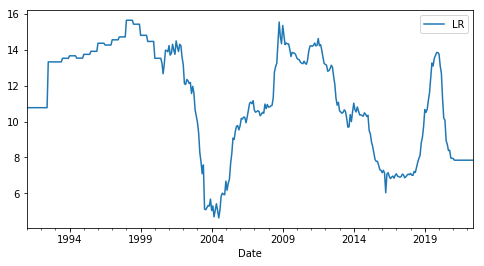

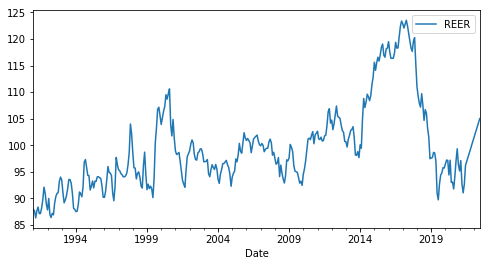

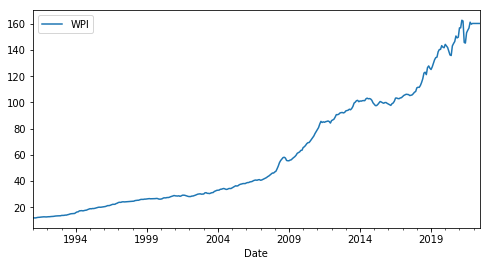

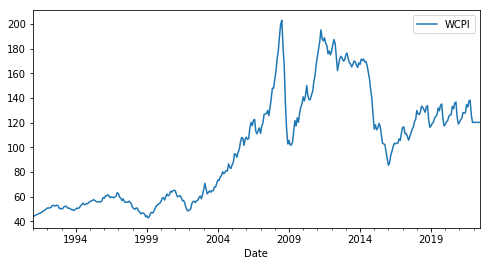

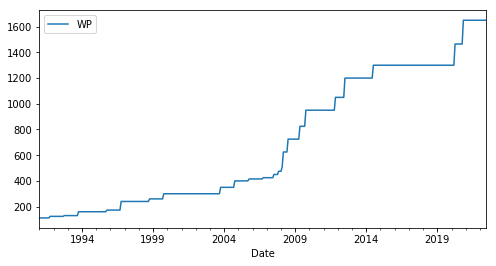

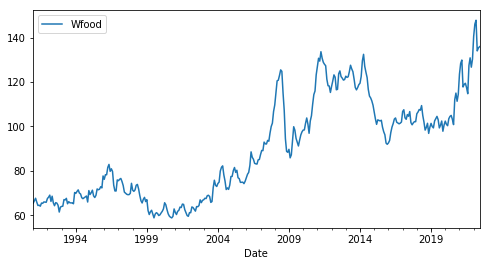

In [17]:
## Line plot all sereis
for (columnName, columnData) in df.iloc[:,1:].iteritems():
    df.plot(x = 'Date',y=columnName,figsize=(8,4))
    plt.show()

**In time sereis problem we have to check if the series is stationary of not because if series is not statinary at levels then
we have to take diference untill it gets stationary.**

**Also we will decompose all the series in seasonal, trend and residual and checkthe series.**

Series: CPI


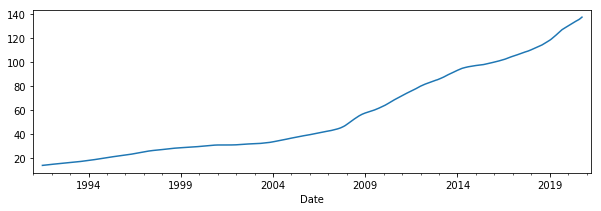

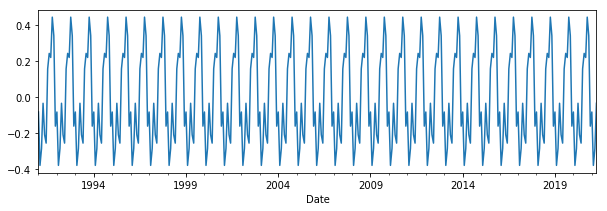

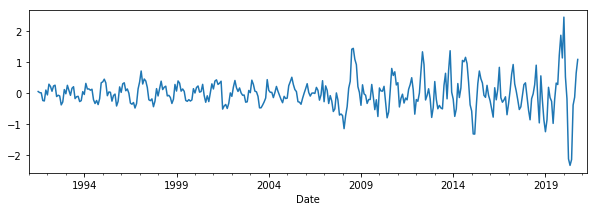

Series: ER


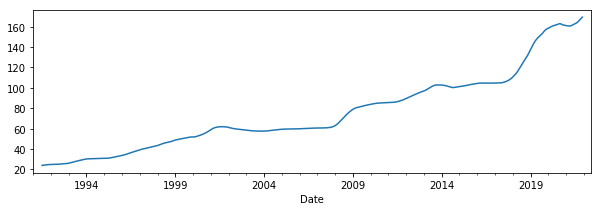

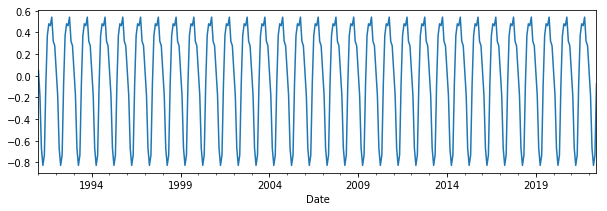

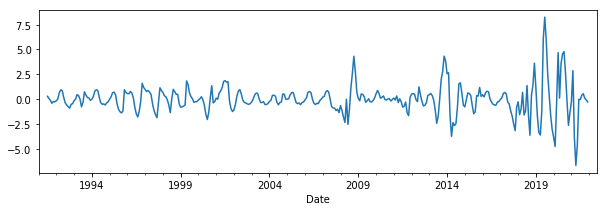

Series: M0


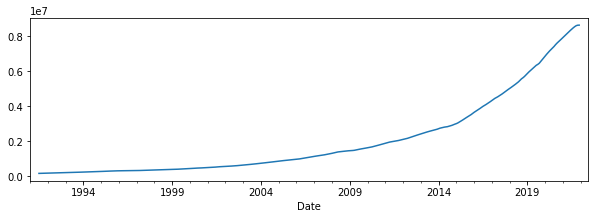

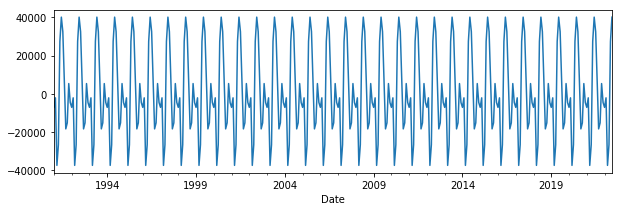

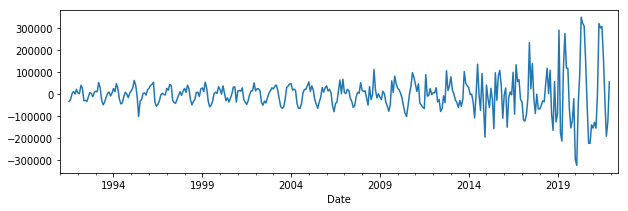

Series: M2


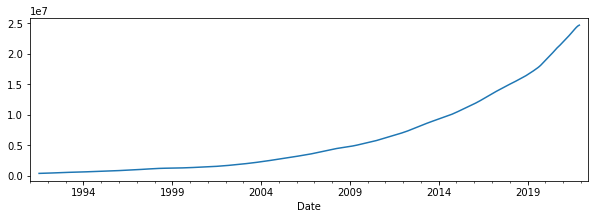

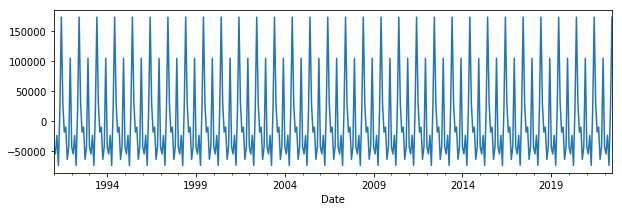

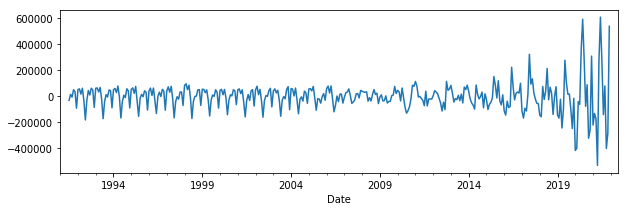

Series: RES


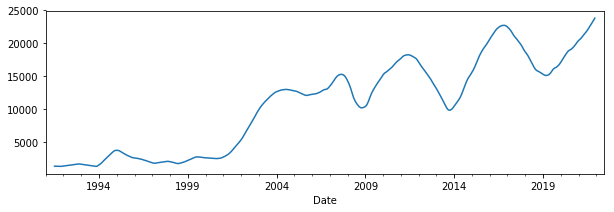

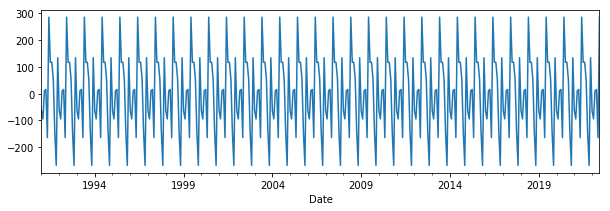

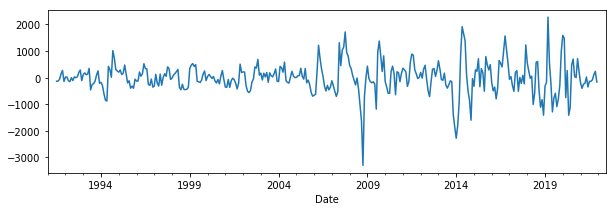

Series: REM


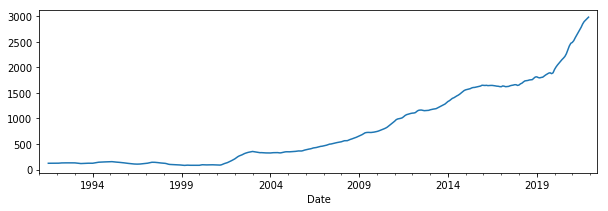

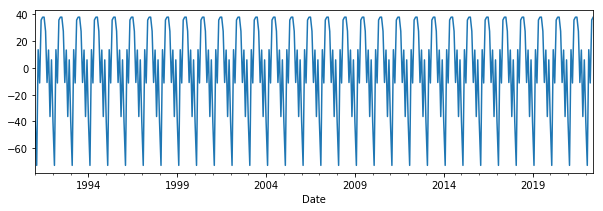

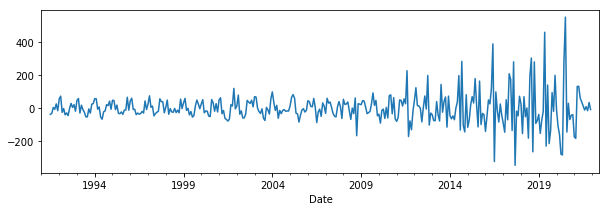

Series: IPLSM


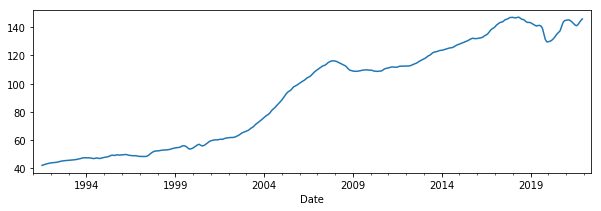

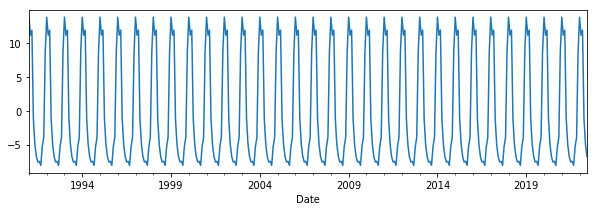

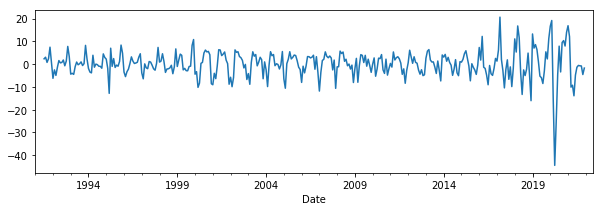

Series: TB


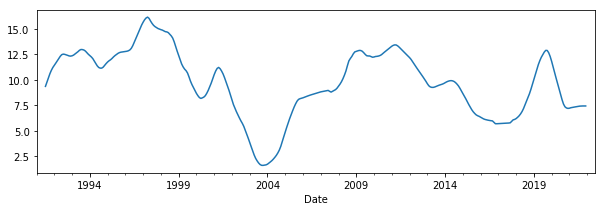

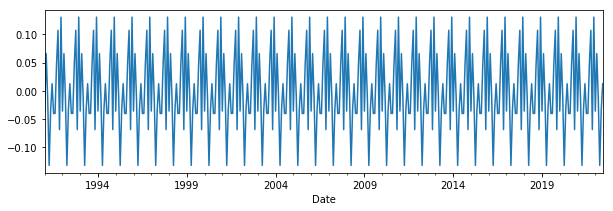

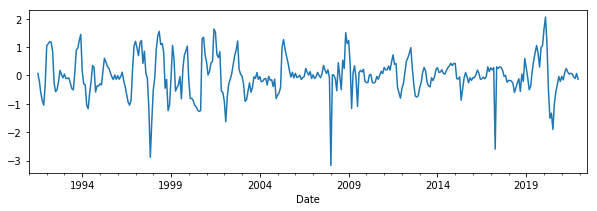

Series: Disr


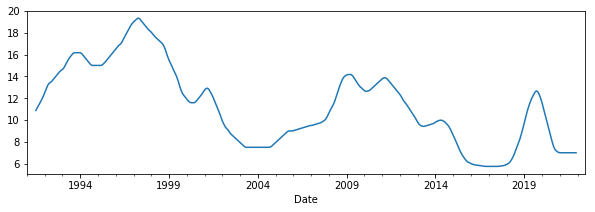

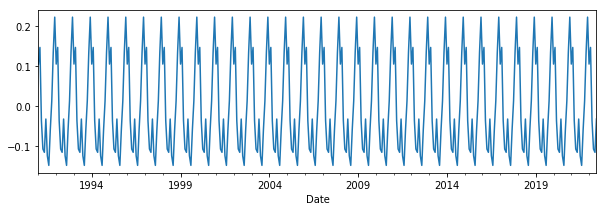

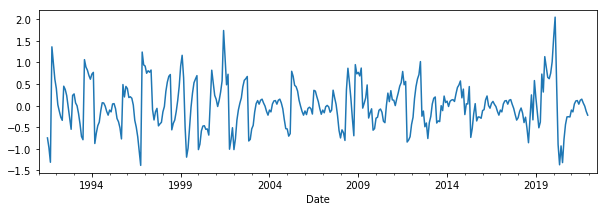

Series: OIL


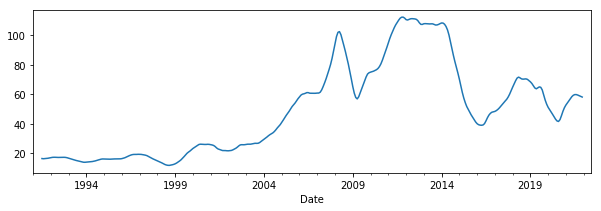

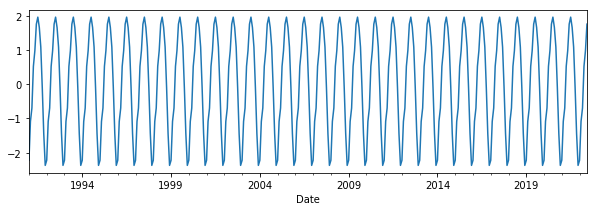

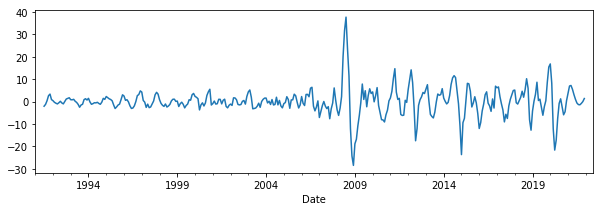

Series: USIPI


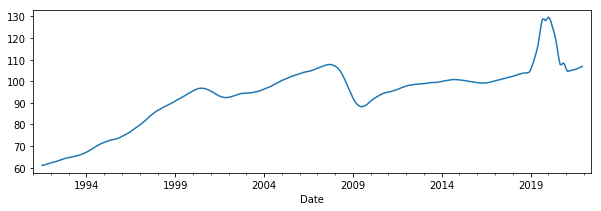

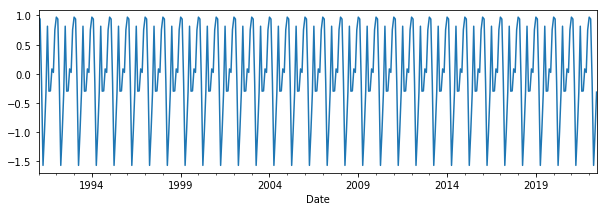

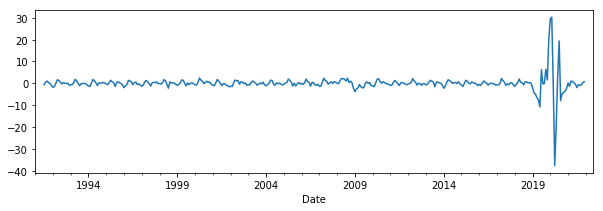

Series: PSC


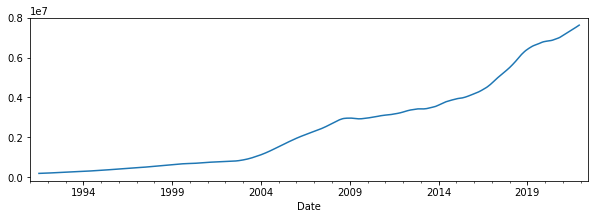

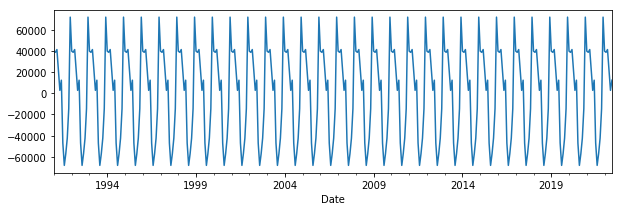

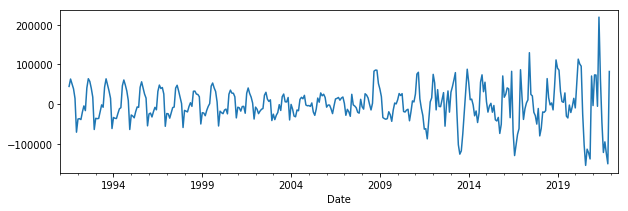

Series: PSB


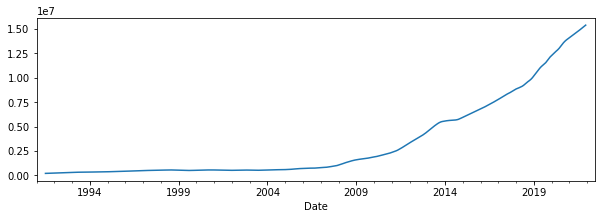

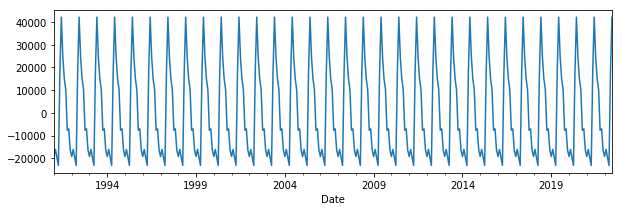

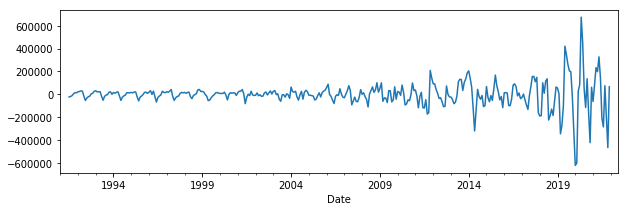

Series: LR


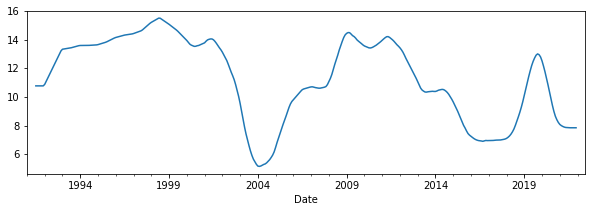

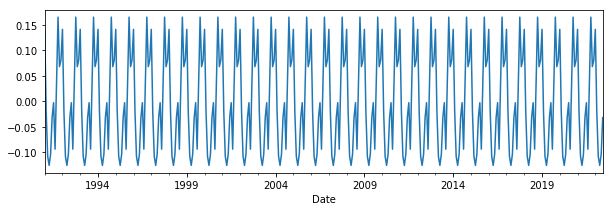

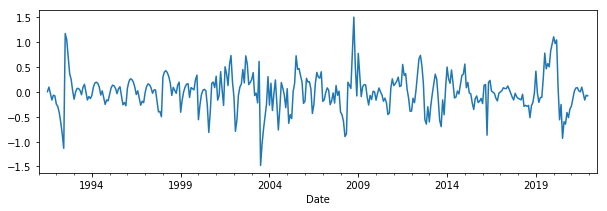

Series: REER


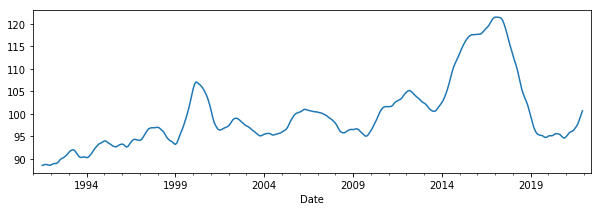

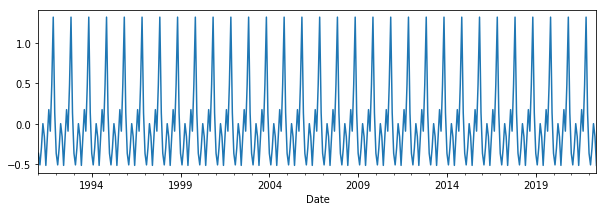

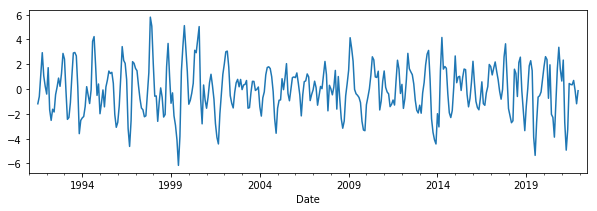

Series: WPI


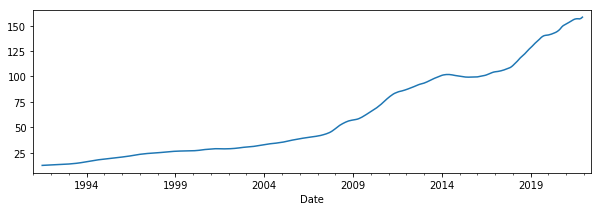

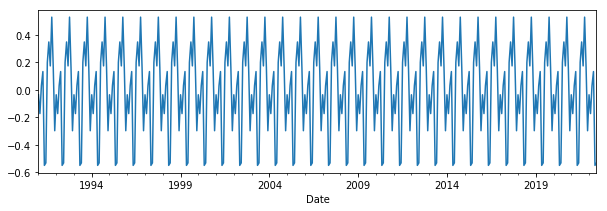

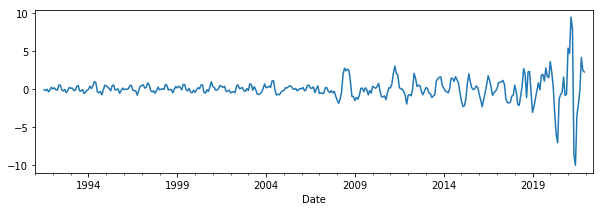

Series: WCPI


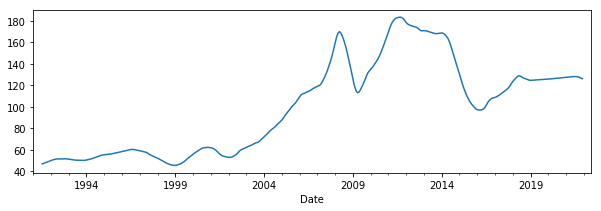

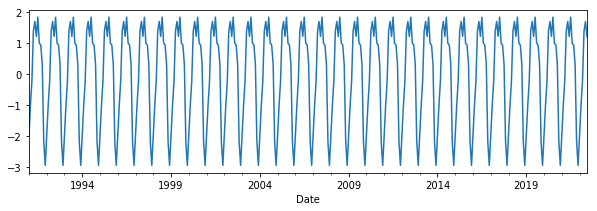

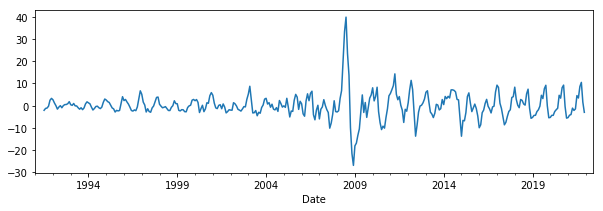

Series: WP


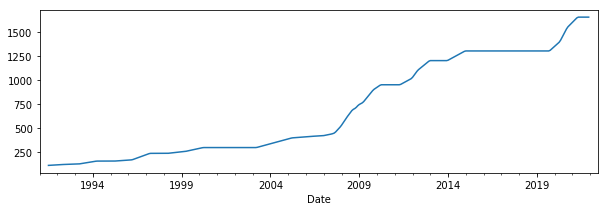

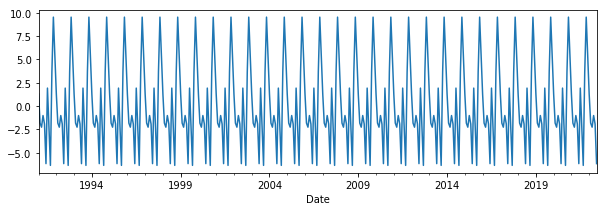

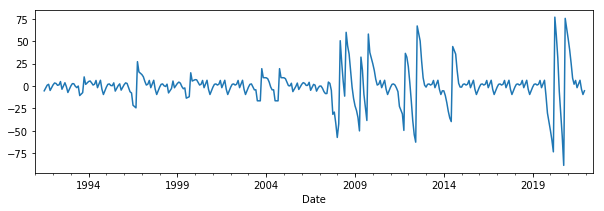

Series: Wfood


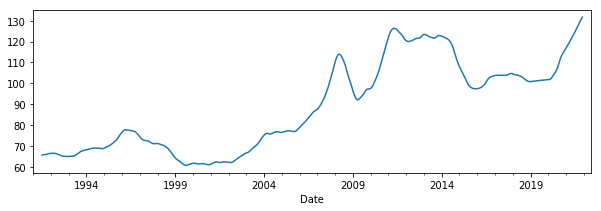

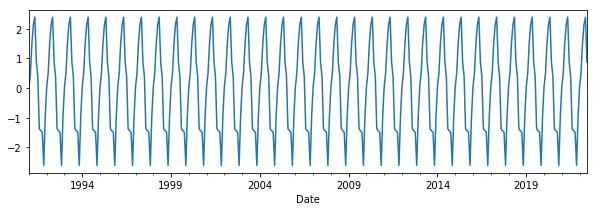

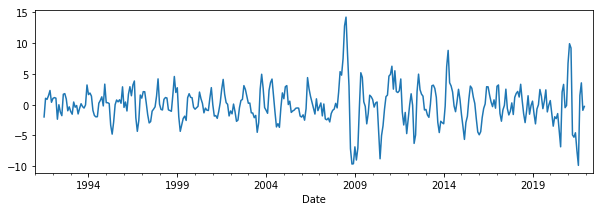

In [73]:
# First seasonally decmposing all series.
df = df.set_index('Date')
for (columnName, columnData) in df.iteritems():
    print('Series:',columnName)
    result = seasonal_decompose(df[columnName].dropna(), model='additive')
    result.trend.plot(figsize=(10,3))
    plt.show()
    result.seasonal.plot(figsize=(10,3))
    plt.show()
    result.resid.plot(figsize=(10,3))
    plt.show()

In [74]:
## Testing statinarity using Agumented Dicky Fuler Unit Root Test
level = []
from statsmodels.tsa.stattools import adfuller
for (columnName, columnData) in df.iteritems():
    print('Series:',columnName)
    X = columnData.dropna().values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1]>0.05):
        print('\033[1m'+'\033[91m'+ "!Fail to reject null hypothesis, series not stationary!"+'\033[0m')
    else:
        print('\033[1m'+'\033[92m'+ "!Null hypothesis rejected, series is stationary!"+'\033[0m')
        level.append(columnName)
    print()
    print()

Series: CPI
ADF Statistic: 2.644542
p-value: 0.999082
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: ER
ADF Statistic: 1.352190
p-value: 0.996886
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: M0
ADF Statistic: -1.207260
p-value: 0.670465
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: M2
ADF Statistic: 2.806514
p-value: 1.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: RES
ADF Statistic: -0.898663
p-value: 0.788412
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: REM
ADF Statistic: 1.935820
p-value: 0.998584
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Serie

**All seen in the test all series are non stationary so taking first difference and then check the statinarity**

In [75]:
first = [] 
for (columnName, columnData) in df.iteritems():   
    print('Series:',columnName)
    X = columnData.diff().dropna().values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1]>0.05):
        print('\033[1m'+'\033[91m'+ "!Fail to reject null hypothesis, series not stationary!"+'\033[0m')
    else:
        print('\033[1m'+'\033[92m'+ "!Null hypothesis rejected, series is stationary!"+'\033[0m')
        if columnName not in level:
            first.append(columnName)
    print()
    print()

Series: CPI
ADF Statistic: -1.396698
p-value: 0.583858
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: ER
ADF Statistic: -4.248181
p-value: 0.000546
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: M0
ADF Statistic: -1.692090
p-value: 0.435192
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: M2
ADF Statistic: -1.411675
p-value: 0.576666
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: RES
ADF Statistic: -4.624926
p-value: 0.000116
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: REM
ADF Statistic: -1.482494
p-value: 0.542153
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Fail to reject null hypothesis, series not stationary!


Series: IPLSM
A

In [76]:
sec = []
for (columnName, columnData) in df.iteritems():   
    print('Series:',columnName)
    X = columnData.diff().diff().dropna().values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1]>0.1):
        print('\033[1m'+'\033[91m'+ "!Fail to reject null hypothesis, series not stationary!"+'\033[0m')
    else:
        print('\033[1m'+'\033[92m'+ "!Null hypothesis rejected, series is stationary!"+'\033[0m')
        if (columnName not in first)&(columnName not in level):
            sec.append(columnName)
    print()
    print()

Series: CPI
ADF Statistic: -7.328748
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: ER
ADF Statistic: -10.329083
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: M0
ADF Statistic: -14.449297
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: M2
ADF Statistic: -4.512905
p-value: 0.000186
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: RES
ADF Statistic: -6.819986
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: REM
ADF Statistic: -11.243084
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
!Null hypothesis rejected, series is stationary!


Series: IPLSM
ADF Statistic: -11.203085


**All series are stationary almost second difference**

In [77]:
print('Series Stationary at Level',level)
print('Series Stationary at First difference',first)
print('Series Stationary at Second difference',sec)

Series Stationary at Level []
Series Stationary at First difference ['ER', 'RES', 'IPLSM', 'TB', 'Disr', 'OIL', 'USIPI', 'LR', 'REER', 'WPI', 'WCPI', 'WP', 'Wfood']
Series Stationary at Second difference ['CPI', 'M0', 'M2', 'REM', 'PSC', 'PSB']


In [112]:
# Making another dataframe with statonary series
d = {'date':pd.Series(pd.period_range("1-1-1991","6-1-2022",freq="M"))}
dfnew = pd.DataFrame(data=d) 
for (columnName, columnData) in df.iteritems():
    if columnName in level:
        dfnew[columnName] = columnData.values
    elif columnName in first:
        dfnew[columnName] = columnData.diff().values
    else:
        dfnew[columnName] = columnData.diff().diff().values

In [108]:
df_details(dfnew,5)

Data Types of Column: 
 CPI      float64
ER       float64
M0       float64
M2       float64
RES      float64
REM      float64
IPLSM    float64
TB       float64
Disr     float64
OIL      float64
USIPI    float64
PSC      float64
PSB      float64
LR       float64
REER     float64
WPI      float64
WCPI     float64
WP       float64
Wfood    float64
dtype: object

 Size of Datarame:  (376, 19)

 Top and bottom  5  rows: 



,CPI,ER,M0,M2,RES,REM,IPLSM,TB,Disr,OIL,USIPI,PSC,PSB,LR,REER,WPI,WCPI,WP,Wfood
date,,,,,,,,,,,,,,,,,,,
1991-03,0.000000,0.353682,5024.0,-365.0,0.000000,5.410000,1.245816,0.0000,0.0,0.40,-0.4,-479.000000,15002.000000,0.0,-1.324734,-0.037867,0.491086,0.0,1.080929
1991-04,0.000000,0.691097,-8031.0,420.0,0.000000,9.950000,-8.198276,1.0400,0.0,0.50,0.2,-2258.000000,-13736.000000,0.0,1.332166,0.222678,0.485757,0.0,-1.741496
1991-05,0.000000,0.491853,3966.0,390.0,0.000000,8.960000,-0.984597,0.5750,0.0,0.55,0.4,-719.000000,-3141.000000,0.0,0.711823,0.196115,0.452383,0.0,-1.525310
1991-06,0.000000,0.382066,-6180.0,16590.0,-61.000000,4.180000,-3.174823,-0.0217,0.0,-0.50,0.6,12407.000000,-3860.000000,0.0,-1.229031,0.027128,0.425536,0.0,0.132114
1991-07,0.798256,0.493317,3618.0,-25887.0,0.000000,-30.270000,2.049569,0.0517,0.0,0.85,0.2,-16339.000000,22657.000000,0.0,0.014693,0.146380,0.408314,0.0,-0.456392
2022-02,NaN,1.300000,0.0,0.0,386.365255,0.298018,-0.537200,0.0000,0.0,0.00,0.0,196795.770852,298752.272758,0.0,0.772181,0.000000,0.000000,0.0,5.479854
2022-03,NaN,1.200000,0.0,0.0,392.547099,0.300998,3.522600,0.0000,0.0,0.00,0.0,-79652.303892,9095.057962,0.0,0.712782,0.000000,0.000000,0.0,1.741507
2022-04,NaN,1.200000,0.0,0.0,398.827852,0.304008,-18.706500,0.0000,0.0,0.00,0.0,-107972.470250,-207989.915850,0.0,0.712782,0.000000,0.000000,0.0,-13.826992
2022-05,NaN,1.300000,0.0,0.0,405.209098,0.307049,-4.883100,0.0000,0.0,0.00,0.0,328147.585417,229050.162509,0.0,0.772181,0.000000,0.000000,0.0,1.340930


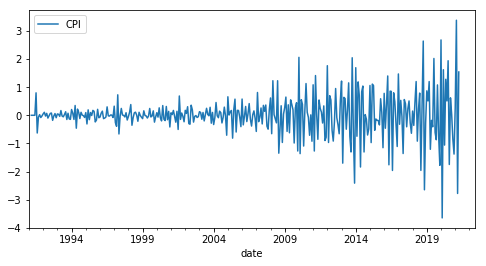

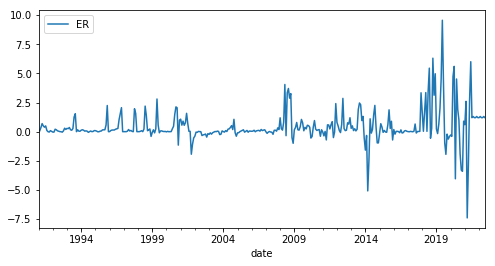

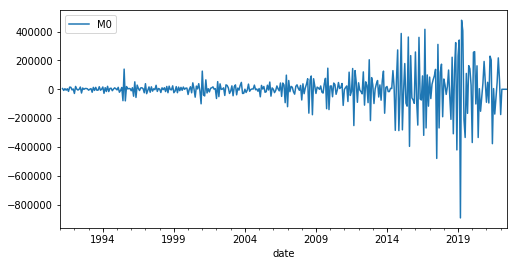

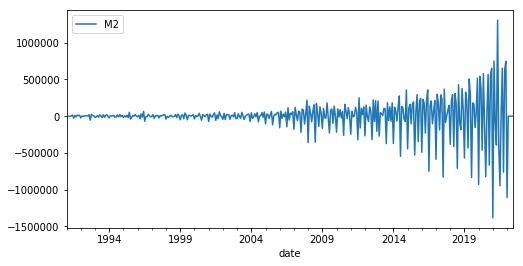

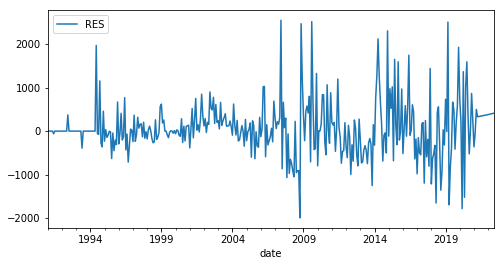

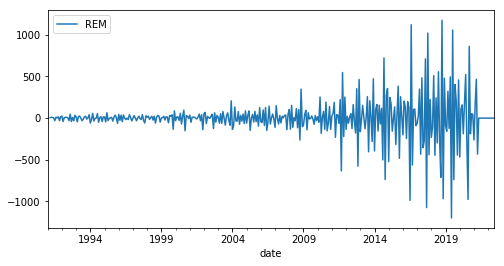

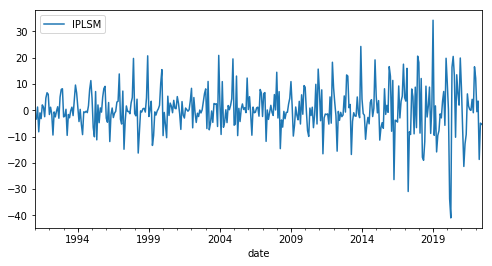

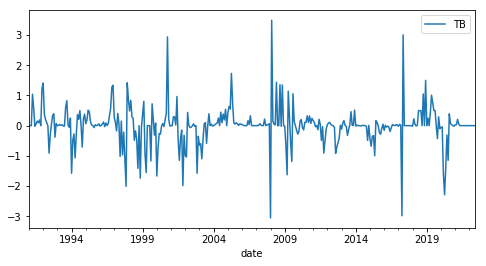

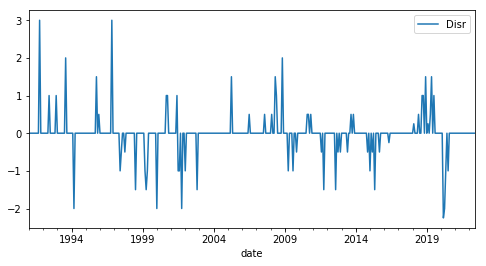

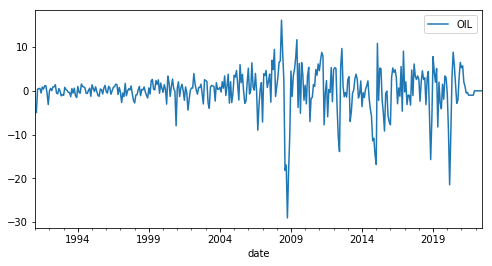

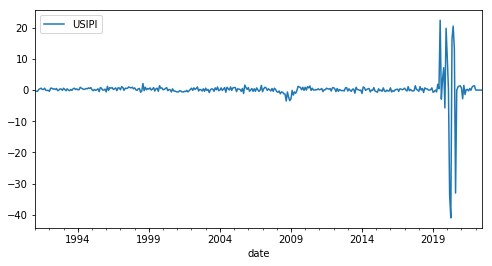

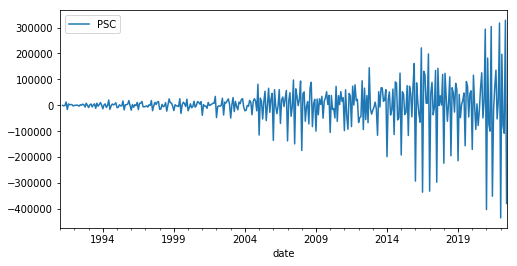

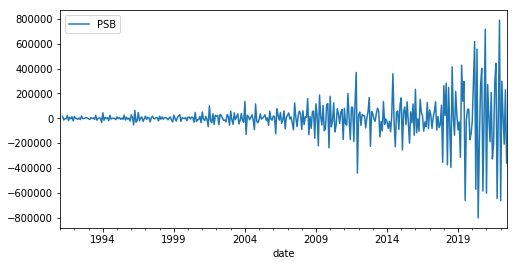

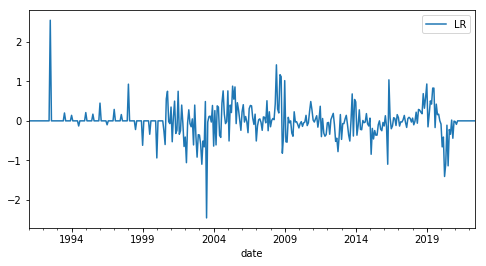

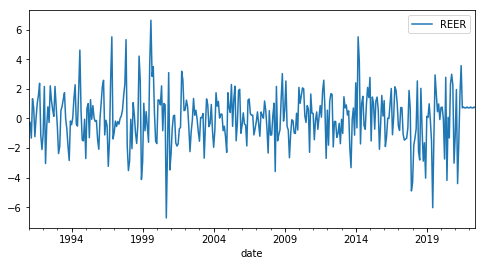

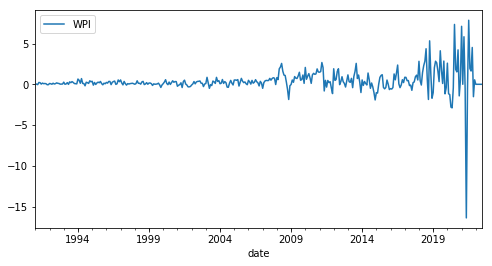

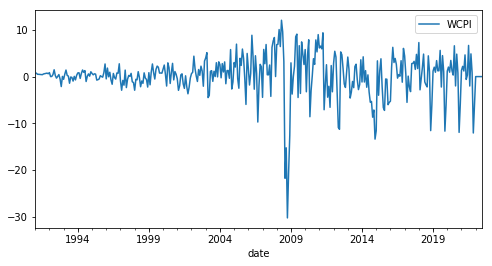

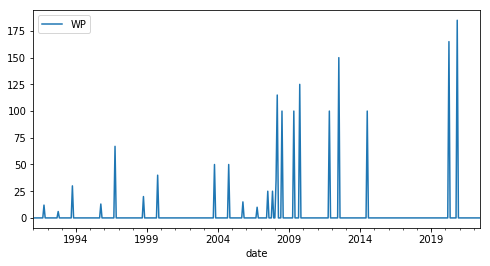

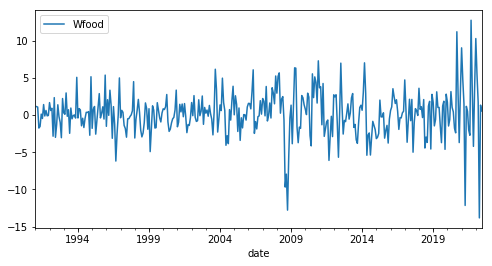

In [80]:
#Visiallizing all after converting them to stationary
## Line plot all sereis
for (columnName, columnData) in dfnew.iloc[:,1:].iteritems():
    dfnew.plot(x = 'date',y=columnName,figsize=(8,4))
    plt.show()

In [91]:
## Droping two columns with NA due to differencing
dfnew = dfnew.drop([0,1],axis=0)

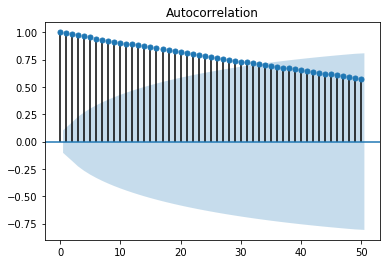

In [96]:
## Ploting Autocorelation Plot
plot_acf(df['CPI'].dropna(),lags=50)
plt.show()

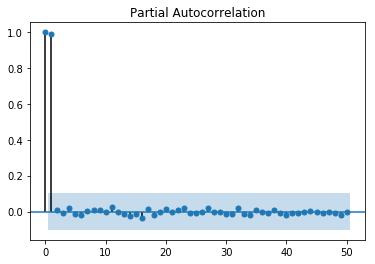

In [97]:
## Ploting Partial Autocorelation Plot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['CPI'].dropna(), lags=50)
plt.show()

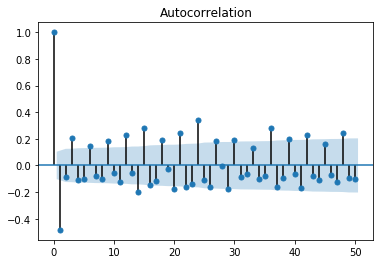

In [98]:
## Ploting of stationary seires Autocorelation Plot
plot_acf(dfnew['CPI'].dropna(),lags=50)
plt.show()

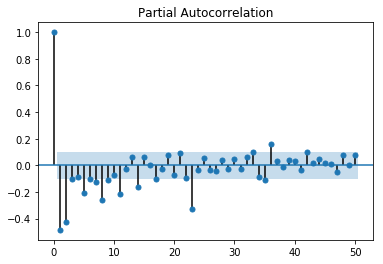

In [99]:
## Ploting Partial Autocorelation Plot of stationary series
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfnew['CPI'].dropna(), lags=50)
plt.show()

As per ACf  the order of MA is 1 and order of AR by PACF is 2

In [120]:
# Index dates
dfnew = dfnew.set_index('date')

In [121]:
# Dropping NA values of CPI
dfnew.dropna(axis=0,inplace=True)
dfnew.tail(4)

,CPI,ER,M0,M2,RES,REM,IPLSM,TB,Disr,OIL,USIPI,PSC,PSB,LR,REER,WPI,WCPI,WP,Wfood
date,,,,,,,,,,,,,,,,,,,
2021-01,0.27,0.6,-90040.297941,-1.387183e+06,-362.600,-261.800,8.280000,0.03,0.0,5.27,0.6872,-402663.236065,-603748.334412,-0.018883,-1.162800,7.11,1.315555,0.0,9.045623
2021-02,3.38,2.6,48453.996922,7.517130e+05,-44.100,155.800,-7.280000,0.03,0.0,5.71,-2.8015,182218.306344,271592.975235,-0.089064,1.952800,0.00,2.189296,0.0,4.814914
2021-03,-2.78,-7.4,-95054.407421,-8.648629e+04,498.700,466.500,-21.372833,0.21,0.0,2.00,1.4992,-73752.133233,8268.234511,0.000000,-4.395491,5.83,1.196335,0.0,1.530188
2021-04,1.54,-2.8,229696.325371,-3.941732e+05,329.656,-431.651,-12.812932,0.05,0.0,1.00,-1.4330,-99974.509491,-189081.741682,0.000000,-1.663159,-0.58,4.637264,0.0,-12.149189


In [122]:
dfnew.iloc[:-12]

,CPI,ER,M0,M2,RES,REM,IPLSM,TB,Disr,OIL,USIPI,PSC,PSB,LR,REER,WPI,WCPI,WP,Wfood
date,,,,,,,,,,,,,,,,,,,
1991-03,0.000000,0.353682,5024.000000,-365.000000,0.000000,5.41,1.245816,0.0000,0.00,0.400000,-0.400000,-479.000000,15002.000000,0.000000,-1.324734,-0.037867,0.491086,0.0,1.080929
1991-04,0.000000,0.691097,-8031.000000,420.000000,0.000000,9.95,-8.198276,1.0400,0.00,0.500000,0.200000,-2258.000000,-13736.000000,0.000000,1.332166,0.222678,0.485757,0.0,-1.741496
1991-05,0.000000,0.491853,3966.000000,390.000000,0.000000,8.96,-0.984597,0.5750,0.00,0.550000,0.400000,-719.000000,-3141.000000,0.000000,0.711823,0.196115,0.452383,0.0,-1.525310
1991-06,0.000000,0.382066,-6180.000000,16590.000000,-61.000000,4.18,-3.174823,-0.0217,0.00,-0.500000,0.600000,12407.000000,-3860.000000,0.000000,-1.229031,0.027128,0.425536,0.0,0.132114
1991-07,0.798256,0.493317,3618.000000,-25887.000000,0.000000,-30.27,2.049569,0.0517,0.00,0.850000,0.200000,-16339.000000,22657.000000,0.000000,0.014693,0.146380,0.408314,0.0,-0.456392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12,-1.780000,-0.421376,29323.605226,517451.168060,1926.642183,457.66,19.793368,-0.1002,0.00,3.030000,19.793370,55759.393117,-123841.878230,0.001117,-0.075369,-0.420000,-6.070100,0.0,2.817900
2020-01,2.680000,-0.283081,-369295.278191,-930026.144812,728.104732,-466.71,10.590205,-0.0601,0.00,-0.610000,10.590200,-170448.192014,-23726.879131,-0.081117,0.745361,2.590000,1.181700,0.0,1.747300
2020-02,-3.650000,-0.405715,256294.899081,543576.604159,222.887042,106.99,0.224914,-0.0397,0.00,-9.000000,0.224920,115924.597447,311581.300682,-0.660000,0.759104,-1.160000,2.040200,0.0,-1.464500


### Using Exponantial Smoothing

In [125]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# prepare data
data = dfnew['CPI'].iloc[:-12].dropna()
# create class
model = ExponentialSmoothing(data,trend='add', seasonal='add',seasonal_periods=12)
# fit model
model_fit = model.fit()
predic = model_fit.forecast(12)

In [127]:
model_fit.summary()

Dep. Variable:,CPI,No. Observations:,350
Model:,ExponentialSmoothing,SSE,113.286
Optimized:,True,AIC,-362.806
Trend:,Additive,BIC,-301.079
Seasonal:,Additive,AICC,-360.739
Seasonal Periods:,12,Date:,"Sat, 29 May 2021"
Box-Cox:,False,Time:,21:25:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4884e-08,beta,True


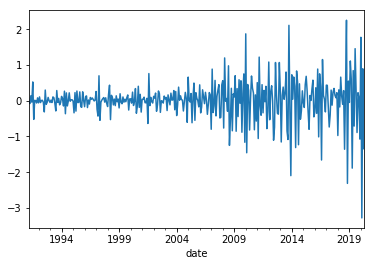

In [129]:
# Residual Plot
model_fit.resid.plot()

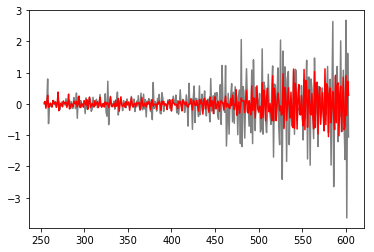

In [138]:
#Ploting Fitted and Actual values
plt.plot(dfnew.index[:-12],dfnew['CPI'].iloc[:-12],color="gray")
plt.plot(dfnew.index[:-12],model_fit.fittedvalues,color="red")


In [133]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(dfnew['CPI'].iloc[-12:], predic, squared=False)
rms1 = mean_squared_error(dfnew['CPI'].iloc[:-12], model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.5689239610259027
RMSE of out of Sample forecast:  1.918042278415232


##  Using ARIMA for forcasting


#### AR

In [140]:
from statsmodels.tsa.arima.model import ARIMA
data = dfnew['CPI'].iloc[:-12].dropna()
# AR model
model = ARIMA(data, order=(2,0,0))
model_fit = model.fit()
predic = model_fit.forecast(12)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  350
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -277.588
Date:                Sat, 29 May 2021   AIC                            563.176
Time:                        22:44:43   BIC                            578.608
Sample:                    03-31-1991   HQIC                           569.319
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.013     -0.145      0.885      -0.028       0.024
ar.L1         -0.7121      0.035    -20.359      0.000      -0.781      -0.644
ar.L2         -0.4731      0.030    -15.838      0.000      -0.532      -0.415
sigma2         0.2854      0.014     20.638      0.000       0.258       0.312
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               159.27
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              27.35   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

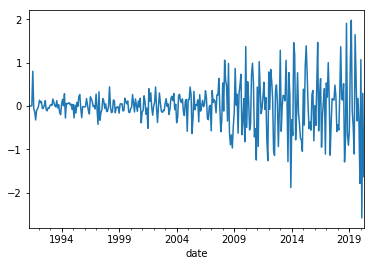

In [141]:
# Residual Plot
model_fit.resid.plot()

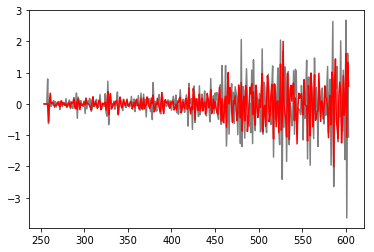

In [142]:
#Ploting Fitted and Actual values
plt.plot(dfnew.index[:-12],dfnew['CPI'].iloc[:-12],color="gray")
plt.plot(dfnew.index[:-12],model_fit.fittedvalues,color="red")

In [143]:
rms = mean_squared_error(dfnew['CPI'].iloc[-12:], predic, squared=False)
rms1 = mean_squared_error(dfnew['CPI'].iloc[:-12], model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.5342272496856852
RMSE of out of Sample forecast:  1.7029121116495982


### MA

In [202]:
data = dfnew['CPI'].iloc[:-12].dropna()
# MA model
model = ARIMA(data, order=(0,0,1))
model_fit = model.fit()
predic = model_fit.forecast(12)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  350
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -263.658
Date:                Sat, 29 May 2021   AIC                            533.317
Time:                        23:42:07   BIC                            544.891
Sample:                    03-31-1991   HQIC                           537.924
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.992      0.321      -0.002       0.005
ma.L1         -0.9452      0.012    -79.635      0.000      -0.969      -0.922
sigma2         0.2625      0.012     21.918      0.000       0.239       0.286
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               193.44
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              28.42   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

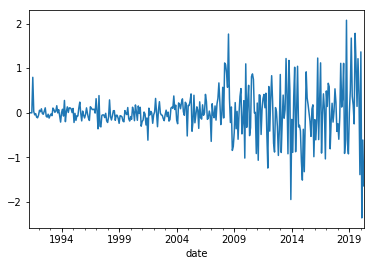

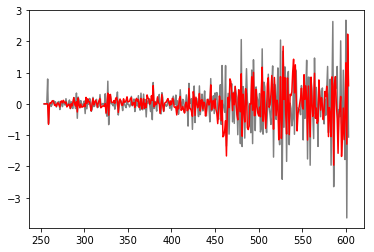

In [203]:
# Residual Plot
model_fit.resid.plot()
plt.show()
#Ploting Fitted and Actual values
plt.plot(dfnew.index[:-12],dfnew['CPI'].iloc[:-12],color="gray")
plt.plot(dfnew.index[:-12],model_fit.fittedvalues,color="red")
plt.show()

In [204]:
rms = mean_squared_error(dfnew['CPI'].iloc[-12:], predic, squared=False)
rms1 = mean_squared_error(dfnew['CPI'].iloc[:-12], model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.5125346531996787
RMSE of out of Sample forecast:  1.6270121741329326


## ARMA

In [212]:
data = dfnew['CPI'].dropna().iloc[:-12]
# MA model
model = ARIMA(data, order=(2,0,1))
model_fit = model.fit()
predic = model_fit.forecast(12)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  350
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -263.558
Date:                Sun, 30 May 2021   AIC                            537.115
Time:                        00:14:51   BIC                            556.405
Sample:                    03-31-1991   HQIC                           544.793
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      1.006      0.314      -0.002       0.005
ar.L1          0.0263      0.042      0.625      0.532      -0.056       0.109
ar.L2          0.0005      0.033      0.015      0.988      -0.064       0.065
ma.L1         -0.9489      0.013    -73.814      0.000      -0.974      -0.924
sigma2         0.2623      0.012     21.095      0.000       0.238       0.287
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               200.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              28.36   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

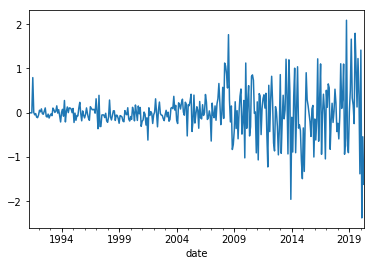

In [213]:
# Residual Plot
model_fit.resid.plot()
plt.show()

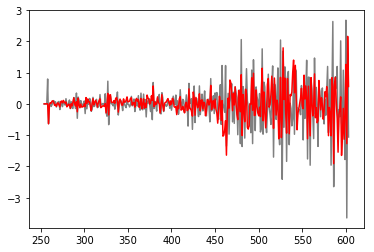

In [215]:
#Ploting Fitted and Actual values
plt.plot(dfnew.index[:-12],data,color="gray")
plt.plot(dfnew.index[:-12],model_fit.fittedvalues,color="red")
plt.show()

In [216]:
rms = mean_squared_error(np.log2(df['CPI'].dropna().iloc[-12:]), predic, squared=False)
rms1 = mean_squared_error(data, model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.5123773492289644
RMSE of out of Sample forecast:  6.994592339610631


### ARIMA

In [182]:
data = np.log2(df['CPI'].dropna().iloc[:-12])
# ARIMA model
model = ARIMA(data, order=(2,1,1))
model_fit = model.fit()
predic = model_fit.forecast(12)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  352
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1075.438
Date:                Sat, 29 May 2021   AIC                          -2142.877
Time:                        23:09:39   BIC                          -2127.434
Sample:                    01-01-1991   HQIC                         -2136.731
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0514      0.063     16.636      0.000       0.928       1.175
ar.L2         -0.0564      0.062     -0.909      0.363      -0.178       0.065
ma.L1         -0.9330      0.021    -43.446      0.000      -0.975      -0.891
sigma2         0.0001    5.3e-06     24.138      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               890.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             1.14
Prob(H) (two-sided):                  0.81   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

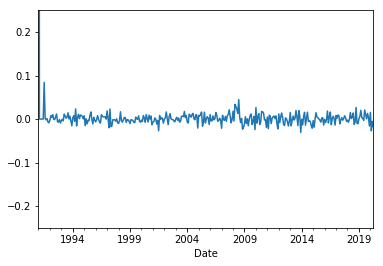

In [183]:
# Residual Plot
model_fit.resid.plot()
plt.ylim([-0.25,0.25])
plt.show()


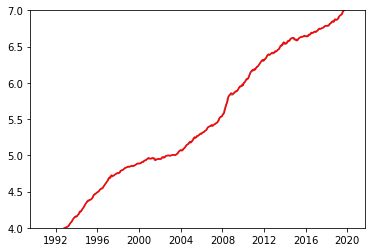

In [191]:
#Ploting Fitted and Actual values
plt.plot(df.dropna().index[:-12],data,color="gray")
plt.plot(df.dropna().index[:-12],model_fit.fittedvalues,color="red")
plt.ylim([4,7])
plt.show()

In [194]:
rms = mean_squared_error(np.log2(df['CPI'].dropna().iloc[-12:]), predic, squared=False)
rms1 = mean_squared_error(data, model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.1989522681713915
RMSE of out of Sample forecast:  0.04444677326928127


## SARIMA

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
data = np.log2(df['CPI'].dropna().iloc[:-12])

model=SARIMAX(endog=data,order=(2,1,1),seasonal_order=(2,1,1,12),trend='c',enforce_invertibility=False)
model_fit = model.fit()
predic = model_fit.forecast(12)
model_fit.summary()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                  352
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                1052.833
Date:                            Sun, 30 May 2021   AIC                          -2089.666
Time:                                    00:13:46   BIC                          -2059.058
Sample:                                01-01-1991   HQIC                         -2077.469
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.449      0.654      -0.001       0.000
ar.L1          0.4551      0.147   

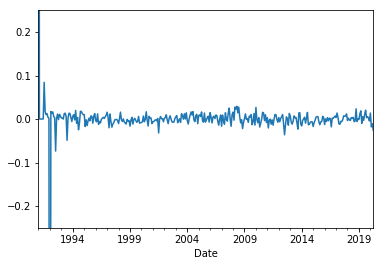

In [209]:
# Residual Plot
model_fit.resid.plot()
plt.ylim([-0.25,0.25])
plt.show()

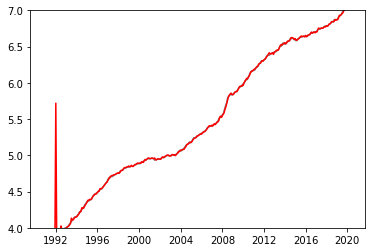

In [210]:
#Ploting Fitted and Actual values
plt.plot(df.dropna().index[:-12],data,color="gray")
plt.plot(df.dropna().index[:-12],model_fit.fittedvalues,color="red")
plt.ylim([4,7])
plt.show()

In [211]:
rms = mean_squared_error(np.log2(df['CPI'].dropna().iloc[-12:]), predic, squared=False)
rms1 = mean_squared_error(data, model_fit.fittedvalues, squared=False)
print("RMSE of Fitted: ",rms1)
print("RMSE of out of Sample forecast: ",rms)

RMSE of Fitted:  0.22223971686606617
RMSE of out of Sample forecast:  0.07208052070229454


## Multivariate LSTM Forecast Model

In [239]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-239-7b363eb856ad>", line 4, in <module>
    from keras.models import Sequential
  File "C:\Users\Sarmad-PC\AppData\Roaming\Python\Python37\site-packages\keras\__init__.py", line 21, in <module>
    from tensorflow.python import tf2
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 963, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 906, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1280, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1246, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1115, in __iter__
  File "<frozen importlib._bootstrap_external>", line 1103, in _recalculate
  File "<frozen importlib._bootstrap_externa

KeyError: 'tensorflow_core'

### In another workbook as require tensor and its install on another Python environment (Python 3.6) so will run LSTM on that note book